In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel, cmdstan_path
import pickle
import json
from scipy.interpolate import splev
from sklearn.metrics import mean_squared_error
from aria.utils.evaluation import smape
from sklearn.preprocessing import PowerTransformer

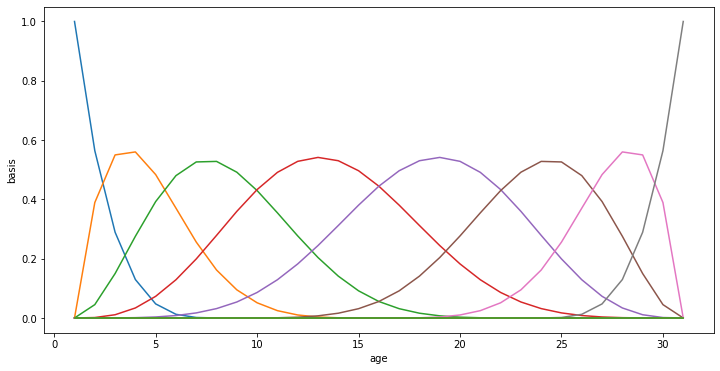

In [2]:
# knot 수에 따라 Bspline 파일 변

degree = 4
knots = np.linspace(1, 31, num=5)
knots_padded = np.concatenate((np.full(degree, 1), knots, np.full(degree, 31)))

basis = []
for i in range(knots_padded.shape[0]):
    c = np.zeros(knots_padded.shape[0])
    c[i] = 1
    basis.append(splev(np.arange(1, 32), (knots_padded, c, degree)))
basis_df = pd.DataFrame(basis).transpose().set_index(np.arange(1, 32))

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.set_ylabel('basis')
basis_df.plot(ax=ax, legend=False)

In [3]:
transformer = PowerTransformer()
y_data_raw = pd.read_csv("../data/y_count_original.csv")
y_data_raw.drop(columns="age", inplace=True)
transformer.fit_transform(y_data_raw.values[~np.isnan(y_data_raw)].reshape(-1, 1))

y_data = pd.read_csv(os.path.realpath("../data/y_count_pwr.csv"), usecols=["y"])
age_data = pd.read_csv(os.path.realpath("../data/x_age.csv"), usecols=["age"])
ship_data = pd.read_csv(os.path.realpath("../data/ship_index.csv"), usecols=["ship"])
ship_engine_mapping_data = pd.read_csv(os.path.realpath("../data/engine_index.csv"), usecols=["engine"])
engine_data = pd.DataFrame({"engine": np.zeros(y_data.shape[0], dtype=np.int32)})
for x in range(y_data.shape[0]):
    engine_data.at[x, "engine"] = ship_engine_mapping_data.at[ship_data.at[x, "ship"]-1, "engine"]


y_data.shape, age_data.shape, ship_data.shape, engine_data.shape, ship_engine_mapping_data.shape

((653, 1), (653, 1), (653, 1), (653, 1), (99, 1))

In [4]:
engine_count = int(np.max(engine_data["engine"]))
ship_count = int(np.max(ship_data["ship"]))
max_age = int(np.max(age_data["age"]))
data_count = int(y_data.shape[0])
engine_count, ship_count, max_age, data_count

(5, 99, 31, 653)

In [5]:
model_file = os.path.join('./models','layer3_nc_diffsd_parammubar.stan')
layer3_model = CmdStanModel(stan_file=model_file) #compile_model(layer3_path)

INFO:cmdstanpy:compiling stan program, exe file: /home/dashadower/git_repos/aria/regression/failure_bma/spline/models/layer3_nc_diffsd_parammubar
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/dashadower/git_repos/aria/regression/failure_bma/spline/models/layer3_nc_diffsd_parammubar


In [6]:
data = {
    "K" : basis_df.shape[1],
    "N" : data_count,  # number of total values
    "T" : max_age,  # length of time of data(31)
    "S" : ship_count, #failure_df.shape[1],  # number of ships(99)
    "E" : engine_count,  # number of unique engines
    "age": age_data["age"].values.tolist(),
    "engine": ship_engine_mapping_data["engine"].values.tolist(),  # engine type mapping
    "ship": ship_data["ship"].values.tolist(),#[int(i) for i in np.where(~np.isnan(failure_df).transpose())[0] + 1],  # ship type mapping
    "Y": y_data["y"].values.tolist(),#failure_df.values[~np.isnan(failure_df)].tolist(),  # all values to list
    "B": basis_df.values.tolist(),  # spline values, 2d list
    "N_hat": data_count,
    "age_hat": age_data["age"].values.tolist(),
    "ship_hat": ship_data["ship"].values.tolist(),
}

In [7]:
%%time
layer3_fit = layer3_model.sample(chains=4, cores=4, data=data, adapt_delta=0.8)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


CPU times: user 562 ms, sys: 38.8 ms, total: 601 ms
Wall time: 2min 21s


In [8]:
layer3_fit.diagnose()

INFO:cmdstanpy:Processing csv files: /tmp/tmpp3zj_yew/layer3_nc_diffsd_parammubar-202008221347-1-kkwmc86l.csv, /tmp/tmpp3zj_yew/layer3_nc_diffsd_parammubar-202008221347-2-2kh8funz.csv, /tmp/tmpp3zj_yew/layer3_nc_diffsd_parammubar-202008221347-3-87677qen.csv, /tmp/tmpp3zj_yew/layer3_nc_diffsd_parammubar-202008221347-4-chrna_30.csv

Checking sampler transitions treedepth.
1 of 4000 (0.025%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
13 of 4000 (0.33%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI sati

"Processing csv files: /tmp/tmpp3zj_yew/layer3_nc_diffsd_parammubar-202008221347-1-kkwmc86l.csv, /tmp/tmpp3zj_yew/layer3_nc_diffsd_parammubar-202008221347-2-2kh8funz.csv, /tmp/tmpp3zj_yew/layer3_nc_diffsd_parammubar-202008221347-3-87677qen.csv, /tmp/tmpp3zj_yew/layer3_nc_diffsd_parammubar-202008221347-4-chrna_30.csv\n\nChecking sampler transitions treedepth.\n1 of 4000 (0.025%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.\nTrajectories that are prematurely terminated due to this limit will result in slow exploration.\nFor optimal performance, increase this limit.\n\nChecking sampler transitions for divergences.\n13 of 4000 (0.33%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI sati

In [9]:
#pd.set_option('display.max_rows', None)
layer3_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-414.517000,0.495841,17.106800,-443.132000,-414.080000,-387.38100,1190.29,4.35765,1.000340
mu_a_bar,-0.096121,0.014481,0.835343,-1.432280,-0.111724,1.27740,3327.72,12.18280,1.000610
mu_w_bar[1],-1.117660,0.009637,0.484279,-1.908700,-1.120150,-0.29701,2525.50,9.24587,1.003510
mu_w_bar[2],0.835181,0.010255,0.511788,0.002526,0.832655,1.68667,2490.69,9.11844,1.003870
mu_w_bar[3],0.343522,0.010980,0.615814,-0.668213,0.331890,1.35652,3145.55,11.51590,1.001180
...,...,...,...,...,...,...,...,...,...
y_new_pred[649],2.176640,0.013212,0.823955,0.835846,2.180390,3.53152,3889.04,14.23780,1.000230
y_new_pred[650],0.494035,0.013521,0.856077,-0.921965,0.481604,1.90787,4008.96,14.67680,0.999775
y_new_pred[651],0.721381,0.014278,0.870633,-0.727516,0.729856,2.13200,3718.16,13.61220,1.000310


In [10]:
pd.reset_option('display.max_rows')

In [25]:
yhat = np.mean(layer3_fit.get_drawset(params=["y_new_pred"]), axis=0).values
yhat.shape

(653,)

In [26]:
mean_squared_error(yhat, y_data["y"].values)

0.48834345281768243

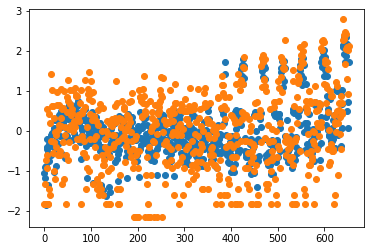

In [27]:
ax = plt.gca()
ax.scatter(np.arange(0, yhat.shape[0]), yhat)
ax.scatter(np.arange(0, yhat.shape[0]), y_data["y"].values)

In [14]:
lambda_ = np.array([0.21649144])
mean_ = np.array([4.96401329])
var_ = np.array([5.32670014])
scale_ = np.array([2.3079645])
n_samples_seen_ = 653
yhat = transformer.inverse_transform(yhat.reshape(-1, 1)).flatten()

In [15]:
yhat

array([  6.58419638,   5.34517612,   8.29512501,   8.73877512,
         0.85382921,  17.00894274,  15.87917359,  22.26574353,
         3.67234722,  14.27712967,  10.55174447,  18.65980993,
        18.00385644,  19.06128261,  25.16452648,  12.95341345,
        26.78443295,  25.82927573,  17.84541179,  18.52012451,
         6.77384264,  30.39763204,  27.67343066,  15.95406849,
        38.20626063,   8.82005057,  24.39366015,  19.79614079,
        37.71583846,  18.65557143,  31.48598363,  32.54468264,
        42.90193305,  24.17500271,  44.57007338,  44.04090965,
        48.31686956,  31.11257614,  32.22323399,  13.73417916,
        36.94666314,  34.79095053,  20.95520115,  46.57010298,
        11.92975787,  42.8742703 ,  30.60518732,  25.17360223,
        45.7681161 ,  24.52468293,  39.0087415 ,  40.94559847,
        53.17923284,  56.2142323 ,  31.30732766,  57.91568087,
        40.19132449,  40.46575263,  39.10925345,  37.32300707,
        21.3581325 ,  50.58279073,  45.0570295 ,  31.10

In [16]:
smape(yhat, transformer.inverse_transform(y_data["y"].values.reshape(-1, 1)).flatten())

0.6268158425350916

In [17]:
mean_squared_error(yhat, transformer.inverse_transform(y_data["y"].values.reshape(-1, 1)).flatten())

690.2423795136898

In [18]:
res = transformer.inverse_transform(y_data["y"].values.reshape(-1, 1)).flatten() - yhat
np.std(res)

25.325286986070893

In [19]:
np.mean(res)

6.990866797961332

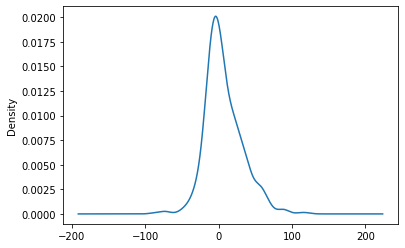

In [20]:
pd.Series(res).plot.kde()

In [21]:
w = layer3_fit.get_drawset(params=["w", "w_bar"])
ship= 1
cols = [f"w.{ship}.{year}" for year in range(1, 14)]
np.mean(w.loc[:, cols], axis=0)

w.1.1    -0.966785
w.1.2     0.986059
w.1.3     0.494399
w.1.4    -0.818614
w.1.5     0.917588
w.1.6     0.135549
w.1.7    -0.173734
w.1.8     0.664539
w.1.9     0.162769
w.1.10    0.150948
w.1.11    0.143203
w.1.12    0.151376
w.1.13    0.158392
dtype: float64

In [22]:
w = layer3_fit.get_drawset(params=["w"])
knot = 13
cols = [f"w.{ship}.{knot}" for ship in range(1, 100)]
np.mean(w.loc[:, cols], axis=0)

w.1.13     0.158392
w.2.13    -0.045338
w.3.13    -0.117155
w.4.13    -0.528728
w.5.13    -0.641088
             ...   
w.95.13   -0.046147
w.96.13    0.241045
w.97.13    0.027844
w.98.13    0.030064
w.99.13   -0.310920
Length: 99, dtype: float64

In [23]:
mu = np.mean(layer3_fit.get_drawset(params=["s_a_bar"]), axis=0)
mu

s_a_bar    2.71437
dtype: float64

In [ ]:
811.465842730105